# 데이콘 이상탐지 데이터 분석
---

In [1]:
!pip install --upgrade matplotlib

In [2]:
!pip install shap

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import pywt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import shap

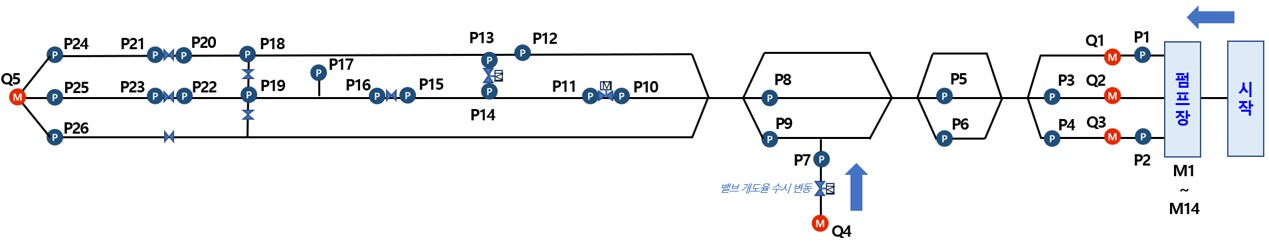

In [4]:
#밸브 개도율 압력계: p7, p10,p11,p13,p14,p15,p16,p18,p19,p20,p21,p22,p23

# M7펌프가 24/06/26 05:58 1에서 0으로 변함
# 압력계가 비정상이되면 14:20-부터 급격히 떨어지다가 정상화된 14:50부터 다시 올라감
- P가 anomaly 관측에 주요 변수로 보임(P8)
- 밸브 개도율 수시 변동과 p8 p9 사이 상관관계 가능
- Q4는 굉장히 중요한 변수다
- Q5가 완전 음에서 완전 양으로 바뀐다
- p7하고 q4가 상관관계 -1에 가까워 q4와 p7사이에 밸브는 개도율이 수시로 변동한다 
- p7이 압력이 높아졌을 때 밸브를 닫아서 q4의 유량이 감소했을 가능성이 있음
- 베르누이 원리에 의해서 정상상태에서는 유량과 압력이 음의 상관관계다
- 근데 anomaly상황에서 q5에서 양의 상관관계다
Anomaly 상황에서 유량과 압력이 양의 상관관계를 보이는 것은 시스템에 비정상적인 상태가 발생했음을 시사합니다. 이는 다음과 같은 상황을 나타낼 수 있습니다:
누수 발생: 파이프라인에 누수가 발생하면, 압력이 증가함에 따라 누수 지점을 통한 유량도 증가할 수 있습니다2. 이는 정상적인 흐름과는 다른 패턴을 보이게 됩니다.
막힘 현상: 파이프라인에 부분적인 막힘이 발생하면, 압력이 증가하면서 동시에 유량도 증가할 수 있습니다. 이는 막힘을 통과하기 위해 더 높은 압력이 필요하기 때문입니다2.
펌프 오작동: 시스템 내 펌프가 비정상적으로 작동하면, 압력과 유량이 동시에 증가하는 현상이 나타날 수 있습니다3.
밸브 오작동: 제어 밸브가 제대로 작동하지 않으면, 압력과 유량 사이의 정상적인 관계가 무너질 수 있습니다.
결론
이러한 관찰 결과는 시스템의 정상 상태와 비정상 상태를 구분하는 중요한 지표가 될 수 있습니다4. 유량과 압력 사이의 관계가 갑자기 변화하는 것은 시스템에 문제가 발생했음을 나타내는 신호일 수 있으며, 이를 통해 조기에 문제를 감지하고 대응할 수 있습니다. 따라서 이러한 패턴 변화를 모니터링하는 것은 수도 공급 시스템의 효율적인 관리와 유지보수에 매우 중요합니다5.

## 이미지 분석과 수압 데이터의 특성을 고려할 때, 다음과 같은 도메인 기반 전처리 방법들을 제안합니다:
1. 시간 도메인 전처리
- Moving Average Filter
세 번째 이미지에서 보이는 급격한 압력 변화 전후의 노이즈 제거
단기(5-10점) 및 장기(20-30점) 이동평균 비교로 변화 패턴 강조
- Exponential Smoothing
최근 데이터에 더 높은 가중치 부여
P8, P9의 급격한 하락 구간 전후의 패턴 포착에 효과적
2. 주파수 도메인 전처리
- Butterworth Filter
Low-pass filter로 고주파 노이즈 제거
압력 변화의 주요 패턴만 추출
차단 주파수: 0.1-0.2Hz 권장
- Wavelet Transform
다중 해상도 분석으로 급격한 압력 변화 감지
Daubechies 웨이블릿 사용 권장
레벨 3-4 분해로 이상 패턴 특성 추출
3. 압력 특성 기반 전처리
- Pressure Gradient Analysis
압력 변화율 계산 및 임계값 설정
급격한 하락 구간 감지에 효과적
- Differential Pressure
인접 압력계 간의 차이 분석
P7-P9 그룹 내 상대적 변화 패턴 포착
4. 통계적 전처리
- Z-score Normalization
압력 변동의 통계적 이상치 감지
이동 윈도우 기반 정규화로 지역적 변화 강조
- CUSUM (Cumulative Sum)
누적 편차 분석으로 변화 시점 탐지
압력 하락 시작점 감지에 효과적
이러한 전처리 방법들을 조합하여 두 번째 이미지의 LOF 성능을 개선할 수 있습니다.

## 이미지 분석 결과를 보면, 각 전처리 방법의 특징이 다음과 같이 나타납니다:
1. Butterworth 필터 적용 (주황색 그래프)
원본 신호의 고주파 노이즈를 효과적으로 제거
P8, P9의 급격한 하락 패턴은 유지하면서 부드러운 신호를 생성
세 번째 이미지의 anomaly 구간(빨간색 영역)의 특성을 잘 보존
2. EMA (녹색 그래프)
이동평균으로 단기적인 변동성 감소
압력 변화의 전반적인 트렌드를 잘 포착
급격한 하락 구간에서도 원신호의 특성을 유지
3. Gradient (빨간색 그래프)
압력 변화율을 명확하게 표시
anomaly 구간에서 큰 음수값으로 급격한 하락을 강조
정상 구간과 이상 구간의 차이가 뚜렷하게 나타남
이러한 전처리된 특성들은 LOF 모델의 입력으로 사용되어 P8, P9의 anomaly 탐지 성능을 개선할 수 있습니다.

이미지 분석을 바탕으로 다음과 같은 전처리와 앙상블 모델 구조를 제안합니다:
1. 전처리 단계
- 1차 전처리: EMA
span=10으로 설정하여 기본 노이즈 제거
급격한 압력 하락 패턴은 보존
전반적인 트렌드를 명확하게 포착
- 2차 전처리: Pressure Gradient
EMA 처리된 데이터의 변화율 계산
이상치 발생 시점의 특성을 강조
급격한 하락 구간에서 뚜렷한 신호 생성
2. 앙상블 모델 구조
- 1단계: Isolation Forest
leakage 기반 1차 필터링
contamination=0.01로 설정
전체적인 이상 구간 후보 선정
- 2단계: One-Class SVM
EMA + Pressure Gradient 특성 사용
필터링된 데이터에 대해 각 Pi별 독립 적용
비선형 커널로 이상치 경계 학습
3. 모델 결합 전략
Isolation Forest로 필터링된 구간 내
One-Class SVM의 예측 결과를 각 Pi_flag에 매핑
각 Pi별 독립적인 flag 예측 수행
이러한 구조는 이미지에서 보이는 P8, P9의 급격한 하락 패턴을 효과적으로 포착하면서도 false positive를 최소화할 수 있습니다.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import pywt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import shap

# 데이터 정보

In [6]:
df_A = pd.read_csv("/Users/gimjaeheon/Desktop/k-water2/open/train/TRAIN_A.csv")

print(df_A.columns)
print("칼럼 수 : ",len(df_A.columns))
print("차원 : ",df_A.shape)


# 새로운 열 생성: Q5 - (Q1 + Q2 + Q3 + Q4)
df_A['leakage'] = df_A['Q1'] + df_A['Q2'] + df_A['Q3'] + df_A['Q4'] - df_A['Q5']

Index(['timestamp', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'P1', 'P2',
       'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13',
       'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23',
       'P24', 'P25', 'P26', 'anomaly', 'P1_flag', 'P2_flag', 'P3_flag',
       'P4_flag', 'P5_flag', 'P6_flag', 'P7_flag', 'P8_flag', 'P9_flag',
       'P10_flag', 'P11_flag', 'P12_flag', 'P13_flag', 'P14_flag', 'P15_flag',
       'P16_flag', 'P17_flag', 'P18_flag', 'P19_flag', 'P20_flag', 'P21_flag',
       'P22_flag', 'P23_flag', 'P24_flag', 'P25_flag', 'P26_flag'],
      dtype='object')
칼럼 수 :  73
차원 :  (44101, 73)


In [7]:
# 압력계 데이터 선택
leakage_cols =['leakage']
df_leakage = df_A[leakage_cols]

In [8]:
# 1. Butterworth 저역통과 필터 적용
#cutoff 주파수 선택이 중요
#너무 낮으면 중요한 변화까지 제거하고 너무 높으면 노이즈가 남음
#필터 차수(order)조정 필요
#높으면 더 급격한 차단특성, 낮은 차수는 더 부드러운 필터링
# 1. Butterworth 필터 적용
def apply_butterworth(data, cutoff=0.1, fs=1.0, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

In [9]:
# 2. Exponential Moving Average with Pressure Gradient
def apply_exp_ma_with_gradient(data, alpha=0.1):
    ema = data.ewm(alpha=alpha).mean()
    gradient = np.gradient(ema)
    return ema, gradient

In [10]:
def apply_wavelet_transform(data, wavelet='db4', level=3):
    # 웨이블렛 분해
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # 근사값(cA)과 상세값(cD) 추출
    cA = coeffs[0]
    cD = coeffs[1:]
    
    # 원본 길이에 맞춰 재구성
    reconstructed = pywt.waverec(coeffs, wavelet)
    
    # 원본 데이터 길이에 맞추기
    if len(reconstructed) > len(data):
        reconstructed = reconstructed[:len(data)]
    elif len(reconstructed) < len(data):
        # 부족한 부분을 0으로 패딩
        padding = np.zeros(len(data) - len(reconstructed))
        reconstructed = np.concatenate([reconstructed, padding])
    
    return reconstructed, cA


In [11]:
# 전처리 적용
df_butter = pd.DataFrame(index=df_leakage.index)
df_ema = pd.DataFrame(index=df_leakage.index)
df_gradient = pd.DataFrame(index=df_leakage.index)
df_wavelet = pd.DataFrame(index=df_leakage.index)

In [12]:
for col in leakage_cols:
    # Butterworth 필터 적용
    df_butter[col] = apply_butterworth(df_leakage[col].values)
    # EMA와 Gradient 적용
    ema, grad = apply_exp_ma_with_gradient(df_leakage[col])
    df_ema[col] = ema
    df_gradient[col] = grad
    # 웨이블렛 변환 적용
    wavelet_rec, _ = apply_wavelet_transform(df_leakage[col].values)
    df_wavelet[col] = wavelet_rec[:len(df_leakage)]

In [13]:
# 시각화
# 시각화 함수 수정
def plot_preprocessing_comparison(original, butter, ema, gradient, wavelet, col):
    plt.figure(figsize=(15, 12))
    
    # 원본 데이터
    plt.subplot(5, 1, 1)
    plt.plot(original[col], label='Original')
    plt.title(f'{col} - Original Data')
    plt.legend()
    
    # Butterworth 필터 결과
    plt.subplot(5, 1, 2)
    plt.plot(butter[col], label='Butterworth', color='orange')
    plt.title(f'{col} - Butterworth Filtered')
    plt.legend()
    
    # EMA 결과
    plt.subplot(5, 1, 3)
    plt.plot(ema[col], label='EMA', color='green')
    plt.title(f'{col} - Exponential Moving Average')
    plt.legend()
    
    # Gradient 결과
    plt.subplot(5, 1, 4)
    plt.plot(gradient[col], label='Pressure Gradient', color='red')
    plt.title(f'{col} - Pressure Gradient')
    plt.legend()
    
    # 웨이블렛 변환 결과
    plt.subplot(5, 1, 5)
    plt.plot(wavelet[col], label='Wavelet Transform', color='purple')
    plt.title(f'{col} - Wavelet Transform')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



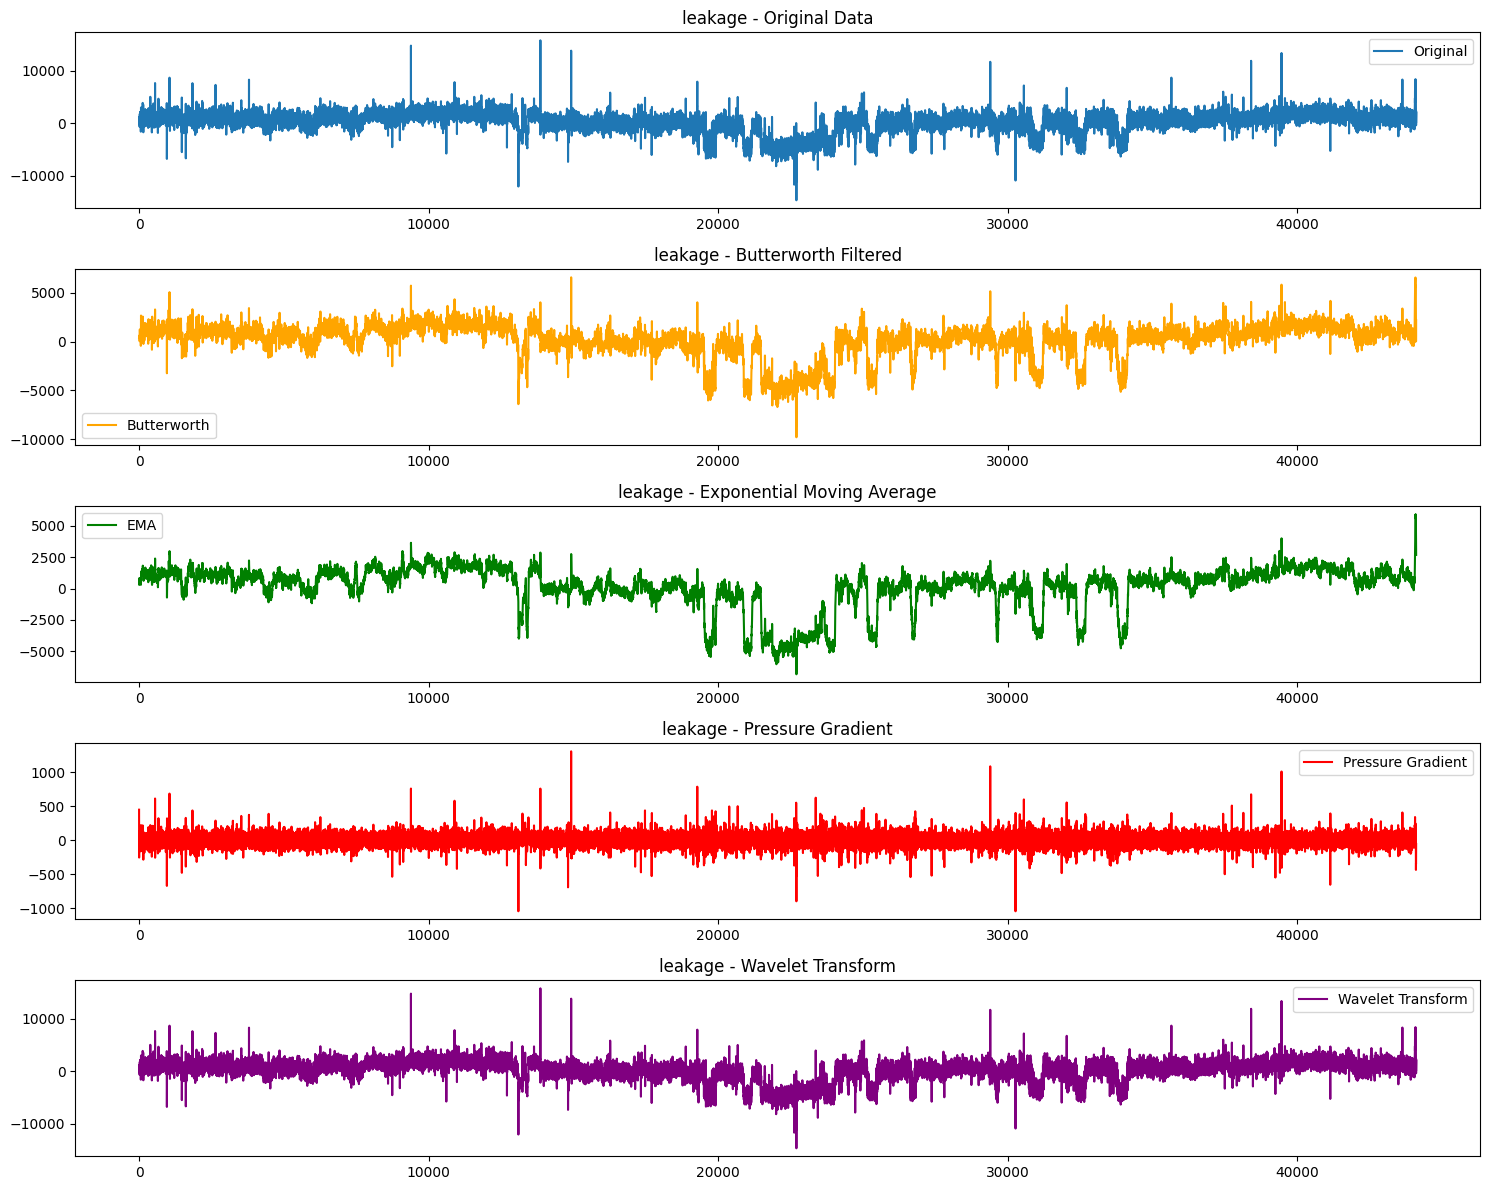

In [14]:
# leakage에 대해 시각화
for col in ['leakage']:
    plot_preprocessing_comparison(
        df_leakage, 
        df_butter, 
        df_ema, 
        df_gradient,
        df_wavelet,
        col
    )

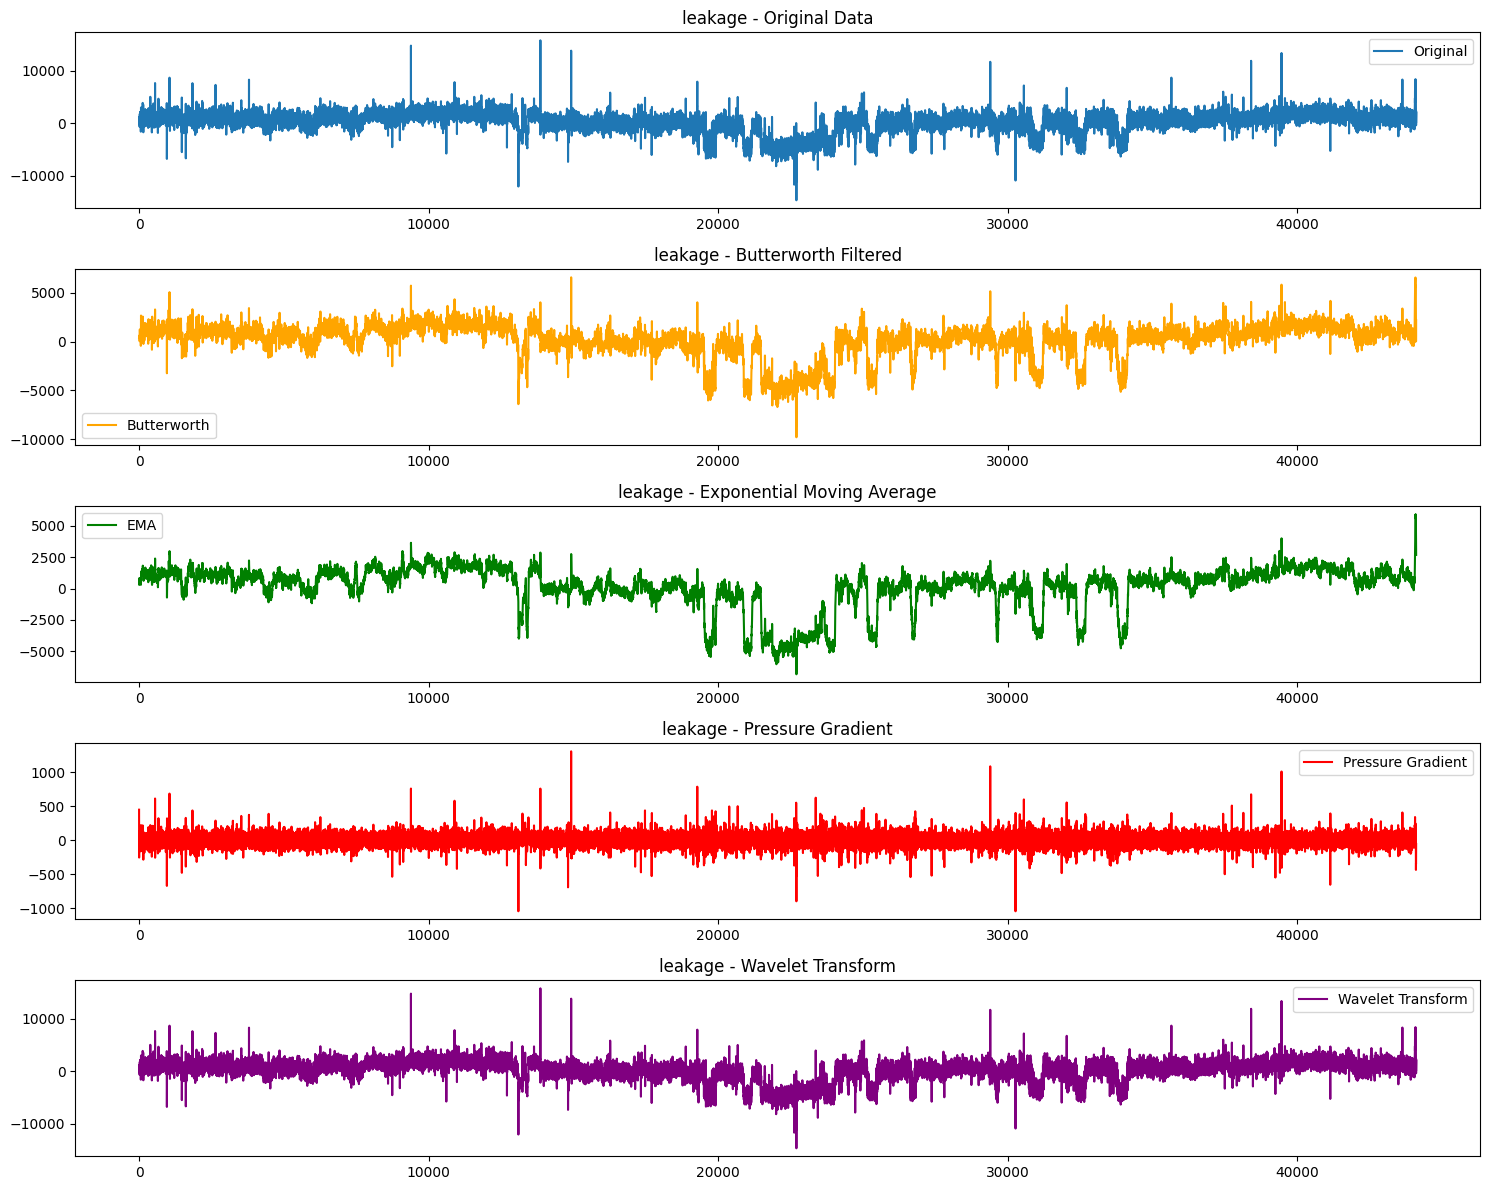

In [15]:
# leakage에 대해 시각화
for col in leakage_cols:
    plot_preprocessing_comparison(
        df_leakage, 
        df_butter, 
        df_ema, 
        df_gradient,
        df_wavelet,
        col
    )

In [16]:
def enhanced_preprocessing_leakage(df, leakage_cols, ema_span=20):
    preprocessed_features = {}
    
    for col in leakage_cols:
        # 1. EMA로 노이즈 제거
        ema = df[col].ewm(span=ema_span, adjust=False).mean()
        
        # 2. 상승 구간 식별
        gradient = ema.diff()
        jump_mask = gradient > 0  # 상승하는 구간 식별
        
        # 3. 상승 구간 특성 추출
        # 상승 기간: 연속된 상승 구간의 길이
        jump_duration = pd.Series(0, index=df.index)
        duration_count = 0
        for i, is_jumping in enumerate(jump_mask):
            if is_jumping:
                duration_count += 1
            else:
                duration_count = 0
            jump_duration.iloc[i] = duration_count
        
        # 상승 폭: 시작점 대비 현재 상승량
        jump_magnitude = pd.Series(0.0, index=df.index)
        start_value = ema.iloc[0]
        for i, is_jumping in enumerate(jump_mask):
            if is_jumping:
                jump_magnitude.iloc[i] = ema.iloc[i] - start_value  # 상승량 계산
            else:
                start_value = ema.iloc[i]
        
        # 상승 속도: gradient의 크기
        jump_speed = gradient.abs() * jump_mask
        
        # 결과 저장
        preprocessed_features['leakage_ema'] = ema
        preprocessed_features['leakage_jump_duration'] = jump_duration
        preprocessed_features['leakage_jump_magnitude'] = jump_magnitude
        preprocessed_features['leakage_jump_speed'] = jump_speed
    
    return pd.DataFrame(preprocessed_features, index=df.index)


In [17]:
# 전처리 적용
leakage_cols = ['leakage']
preprocessed_df = enhanced_preprocessing_leakage(df_A, leakage_cols)
print(preprocessed_df)

       leakage_ema  leakage_jump_duration  leakage_jump_magnitude  \
0       358.002000                      0                0.000000   
1       439.144857                      1               81.142857   
2       384.273918                      0                0.000000   
3       338.057355                      0                0.000000   
4       351.385321                      1               13.327966   
...            ...                    ...                     ...   
44096  3591.080486                      0                0.000000   
44097  3299.358631                      0                0.000000   
44098  2947.610285                      0                0.000000   
44099  2815.171496                      0                0.000000   
44100  2753.631639                      0                0.000000   

       leakage_jump_speed  
0                     NaN  
1               81.142857  
2                0.000000  
3                0.000000  
4               13.327966  
...

In [18]:
def plot_preprocessing_results(df_A, preprocessed_df, col):
    plt.figure(figsize=(15, 10))
    
    # 원본 데이터와 EMA
    plt.subplot(3, 1, 1)
    plt.plot(df_A['leakage'], label='Original', alpha=0.7)
    plt.plot(preprocessed_df['leakage_ema'], label='EMA', alpha=0.7)
    
    # 상승 특성
    plt.subplot(3, 1, 2)
    plt.plot(preprocessed_df['leakage_jump_magnitude'], label='jump Magnitude', color='red')
    plt.plot(preprocessed_df['leakage_jump_speed'], label='jump Speed', color='blue')
  
    plt.title('Jump Characteristics')
    plt.legend()
    
    # 상승 기간
    plt.subplot(3, 1, 3)
    plt.plot(preprocessed_df[f'{col}_jump_duration'], label='jump Duration', color='green')

    plt.title('jump Duration')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



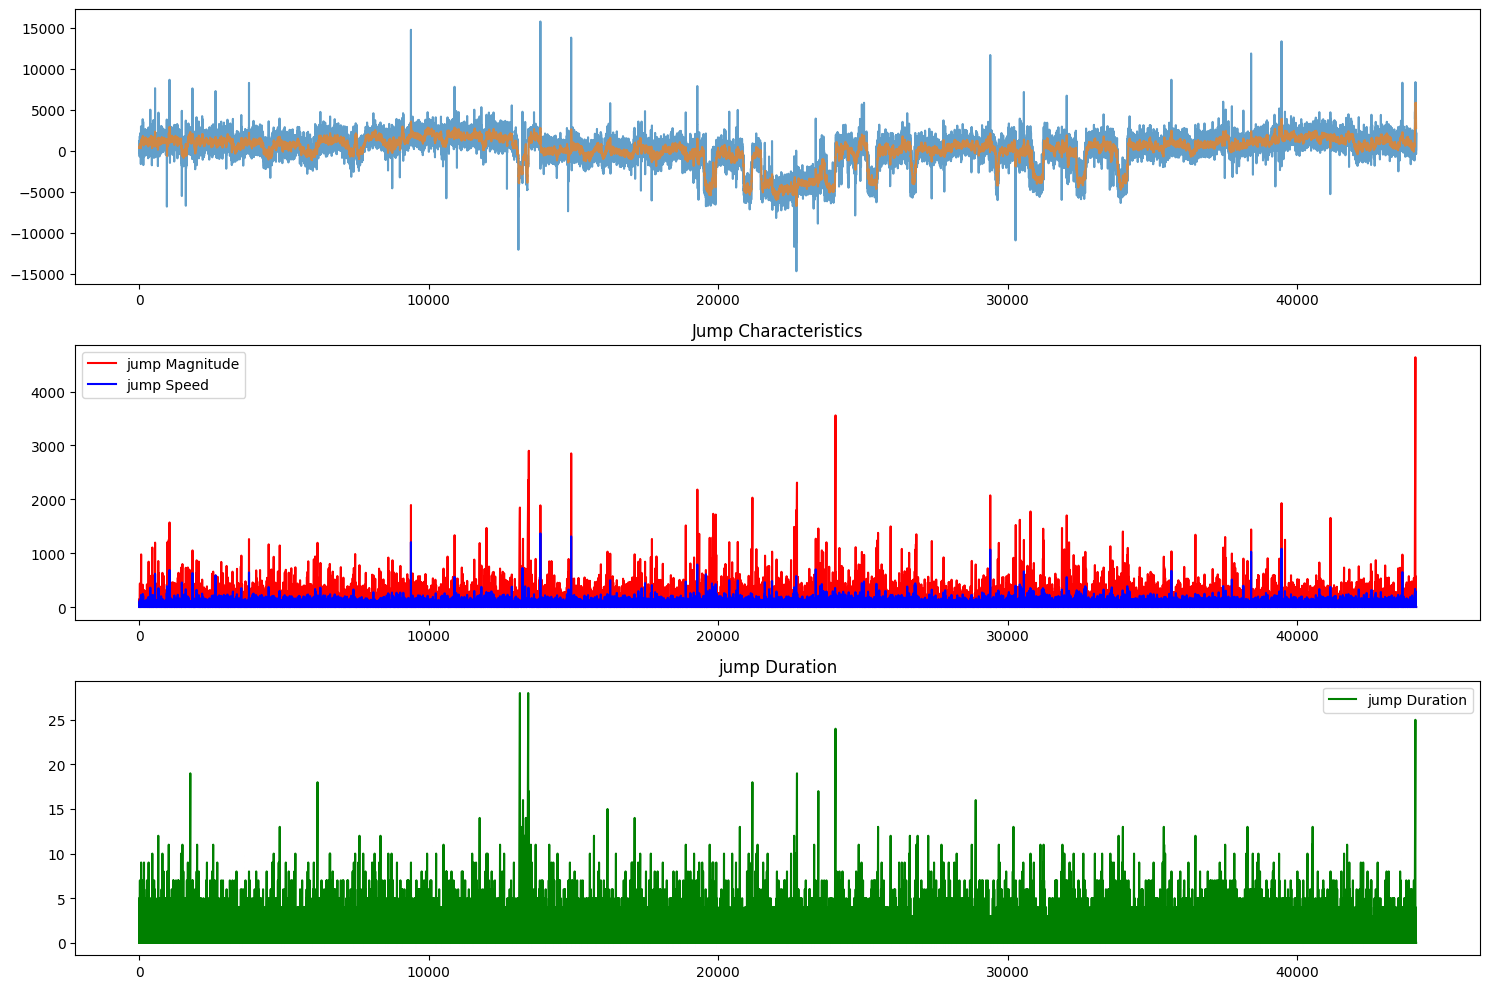

In [19]:
# leakage에 대해 결과 시각화
for col in leakage_cols:
    plot_preprocessing_results(df_A, preprocessed_df, col)

## 이미지와 평가 결과를 분석해보면, SVM 모델의 성능을 개선하기 위해 다음과 같은 방법들을 제안할 수 있습니다:
1. 하락 특성 기반 전처리 개선
Drop Duration 임계값 설정: 연속된 하락 기간이 특정 기간 이상인 경우만 고려
Drop Magnitude 정규화: 하락 폭을 상대적 비율로 변환
Drop Speed와 Duration의 조합 특성 생성
2. SVM 하이퍼파라미터 최적화
nu 값을 0.001로 낮추어 이상치 비율 조정
kernel을 'rbf'에서 'sigmoid'로 변경 시도
gamma 파라미터를 'auto'로 설정하여 특성 간 관계 강화
3. 모델링 전략 수정
하락 구간에 대해서만 SVM 적용
연속된 이상치 탐지 시에만 flag로 판단
급격한 하락이 발생하는 구간의 길이를 고려한 후처리
4. 앙상블 접근
Isolation Forest로 1차 필터링
SVM으로 2차 이상치 탐지
두 모델의 예측이 일치하는 경우만 flag로 판단
이미지에서 보이는 P8, P9의 급격한 하락 패턴과 실제 flag 발생 구간의 특성을 더 잘 반영하도록 이러한 개선이 필요합니다.

`-` 해결해야할 문제 : P 압력계에서 일어나는 이상치를 탐지

- Q1 ~ Q5 : 유량 정량 정보
- M1 ~ M14 : 이진 분류되어진 펌프가동정보, 이산형 데이터 0이면 꺼진거 1이면 켜진거
- P1 ~ P26 : 해당 펌프의 상수도의 압력계 정량 정보 0이면 정상 1이면 이상치!!
- P1_flag ~ P26_flag : 어떠한 P에 이상 탐지 여부, 이진 분류, test set에선 제공되지 않는다
- anomaly : 이상 탐지 여부, train set에서만 존재, P1_flag ~ P26_flag에서 감지되면 해당 변수에서도 체크된다, test set에선 제공되지 않는다
- Data set : $ D_{train} \in R^{n \times m} $ , $n = 1,2,...,44101,\quad m = 1,2,...,73$
- $n$단위는 1분, 결측치 존재 X


# iso forest

In [20]:
# 1. Leakage 특성 생성
leakage_cols = ['leakage']
preprocessed_leakage = enhanced_preprocessing_leakage(df_A, leakage_cols)



In [21]:
# 2. 특성 데이터 준비
features = pd.DataFrame({
    'leakage': df_A['leakage'],
    'jump_duration': preprocessed_leakage['leakage_jump_duration'],
    'jump_magnitude': preprocessed_leakage['leakage_jump_magnitude'],
    'jump_speed': preprocessed_leakage['leakage_jump_speed']
}).fillna(0)






In [22]:
# 2. Isolation Forest 모델 정의
iso_forest = IsolationForest(
    contamination=0.03,
    random_state=42,
    n_estimators=100
)



In [23]:
# 3. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)



In [24]:
# 4. 모델 학습 및 예측
iso_forest.fit(X_scaled)
anomaly_pred = iso_forest.predict(X_scaled)
df_A['predicted_anomaly'] = np.where(anomaly_pred == -1, 1, 0)


In [25]:
# 5. 시각화
plt.figure(figsize=(15, 8))

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

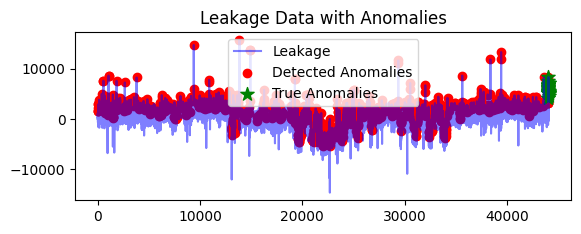

In [26]:
# 원본 데이터와 예측 결과
plt.subplot(2, 1, 1)
plt.plot(df_A.index, df_A['leakage'], 'b-', label='Leakage', alpha=0.5)
plt.scatter(df_A.index[df_A['predicted_anomaly'] == 1],
           df_A.loc[df_A['predicted_anomaly'] == 1, 'leakage'],
           color='red', label='Detected Anomalies')
plt.scatter(df_A.index[df_A['anomaly'] == 1],
           df_A.loc[df_A['anomaly'] == 1, 'leakage'],
           color='green', marker='*', s=100, label='True Anomalies')
plt.title('Leakage Data with Anomalies')
plt.legend()

In [27]:
# 6. 성능 평가
true_anomalies = df_A[df_A['anomaly'] == 1]
detected_anomalies = df_A[df_A['predicted_anomaly'] == 1]
matching = df_A[(df_A['anomaly'] == 1) & (df_A['predicted_anomaly'] == 1)]

print(f"실제 anomaly 수: {len(true_anomalies)}")
print(f"탐지된 anomaly 수: {len(detected_anomalies)}")
print(f"일치하는 anomaly 수: {len(matching)}")
print(f"탐지 정확도: {len(matching)/len(true_anomalies)*100:.2f}%")


실제 anomaly 수: 30
탐지된 anomaly 수: 1323
일치하는 anomaly 수: 17
탐지 정확도: 56.67%


In [67]:
def detect_pressure_anomalies_iso(preprocessed_df, leakage_cols, contamination=0.01):
    # 1. 하락 특성 선택
    jump_features = []
    for col in leakage_cols:
        jump_features.extend([
            'leakage_drop_duration',
            'leakage_drop_magnitude',
            'leakage_drop_speed'
        ])
    
    # 결측치 처리
    features_df = preprocessed_df[jump_features].fillna(0)
    
    # 2. Isolation Forest 적용
    iso = IsolationForest(
        contamination=0.1,
        random_state=42,
        n_estimators=100
    )
    
    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features_df)
    
    # 예측
    predictions = iso.fit_predict(X_scaled)
    anomalies = np.where(predictions == -1, 1, 0)
    
    
 
    return results, feature_importance

In [69]:
def detect_pressure_anomalies_iso(preprocessed_df, leakage_cols, contamination=0.01):
    # 1. 하락 특성 선택
    jump_features = []
    for col in leakage_cols:
        jump_features.extend([
            f'{col}_jump_duration',
            f'{col}_jump_magnitude',
            f'{col}_jump_speed'
        ])
    
    # 결측치 처리
    features_df = preprocessed_df[jump_features].fillna(0)
    
    # 2. Isolation Forest 적용
    iso = IsolationForest(
        contamination=0.1,
        random_state=42,
        n_estimators=100
    )
    
    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features_df)
    
    # 예측
    predictions = iso.fit_predict(X_scaled)
    anomalies = np.where(predictions == -1, 1, 0)
    
    # 3. SHAP 값 계산
    explainer = shap.TreeExplainer(iso)
    shap_values = explainer.shap_values(X_scaled)
    
    # 4. 각 특성별 영향도 분석
    feature_importance = {}
    for i, feature in enumerate(jump_features):
        feature_importance[feature] = np.mean(np.abs(shap_values[:, i]))
    
    # 결과 생성
    results = pd.DataFrame()
    results['iso_anomaly'] = anomalies
    
    return results, feature_importance


In [70]:
# 모델 적용
results, importance = detect_pressure_anomalies_iso(preprocessed_df, leakage_cols)

In [30]:
# 결과 시각화
def plot_importance_and_predictions(importance, results, original_df):
    plt.figure(figsize=(12, 6))
    
    # 특성 중요도 시각화
    importance_df = pd.DataFrame(
        list(importance.values()),
        index=list(importance.keys())
    ).sort_values(0, ascending=True)
    
    plt.barh(range(len(importance_df)), importance_df[0])
    plt.yticks(range(len(importance_df)), importance_df.index)
    plt.title('Feature Importance based on SHAP values')
    plt.tight_layout()
    plt.show()
    
    # P8, P9 예측 결과 시각화
    for col in ['P8', 'P9']:
        plt.figure(figsize=(15, 5))
        plt.plot(original_df[col], label='Original', alpha=0.7)
        
        # 실제 flag
        true_flags = original_df[original_df[f'{col}_flag'] == 1].index
        plt.scatter(true_flags, original_df.loc[true_flags, col],
                   color='green', marker='*', s=100, label='True Flag')
        
        # 예측 flag
        pred_flags = results[results[f'{col}_flag_pred'] == 1].index
        plt.scatter(pred_flags, original_df.loc[pred_flags, col],
                   color='red', marker='x', s=50, label='Predicted Flag')
        
        plt.title(f'{col} - Predictions vs True Flags')
        plt.legend()
        plt.show()

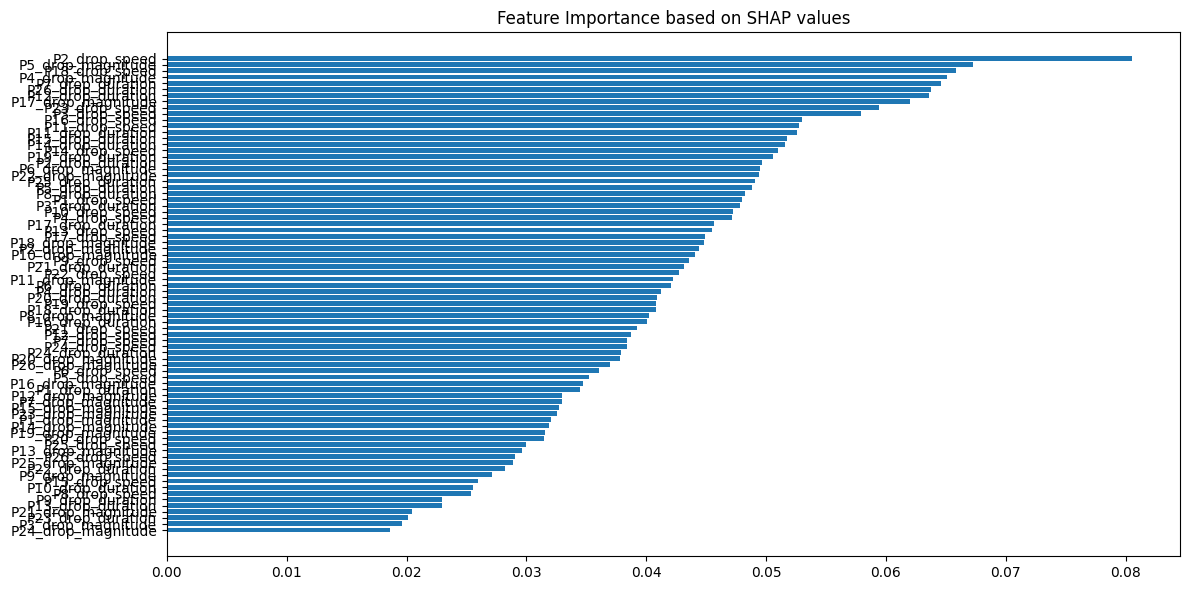

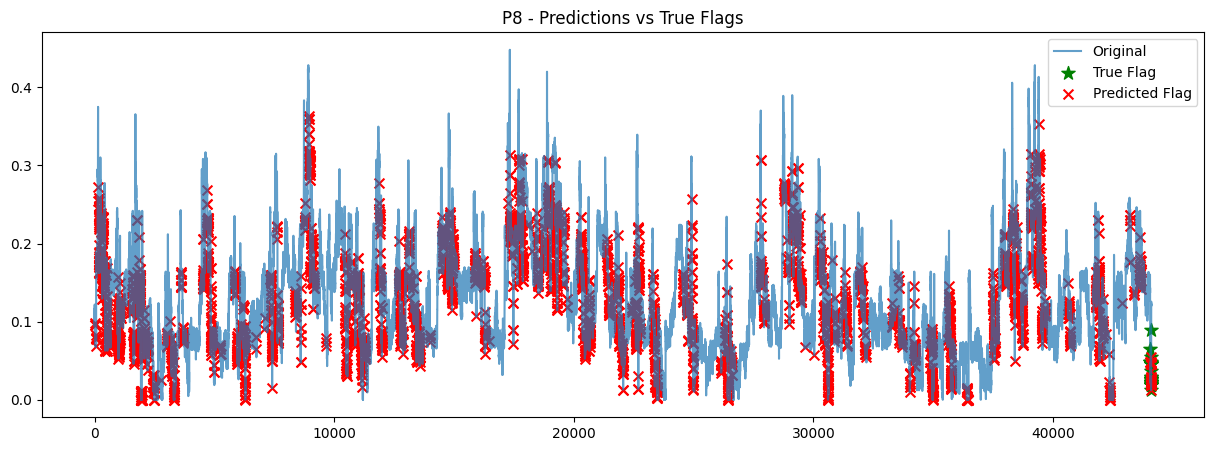

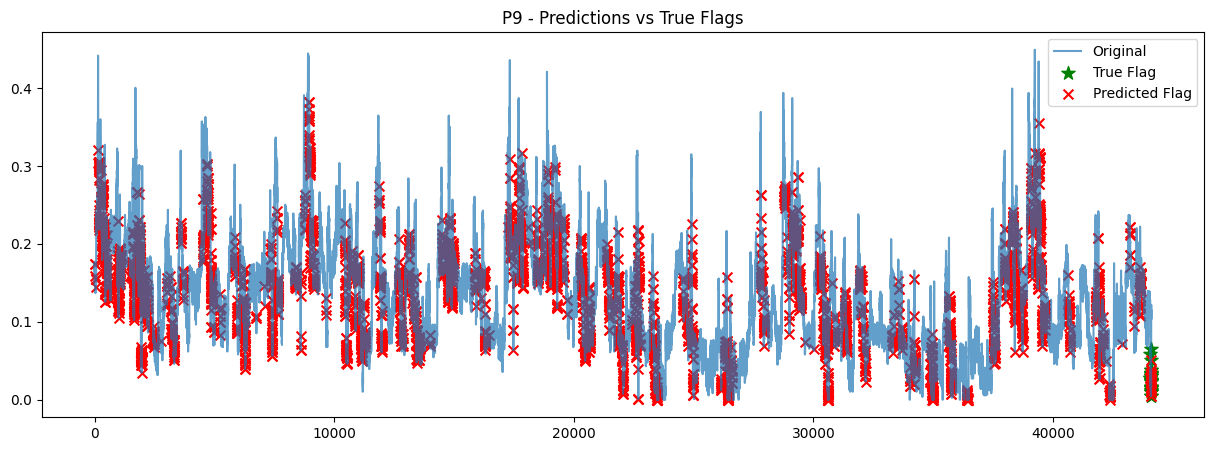

In [31]:
# 결과 시각화
plot_importance_and_predictions(importance, results, df_A)

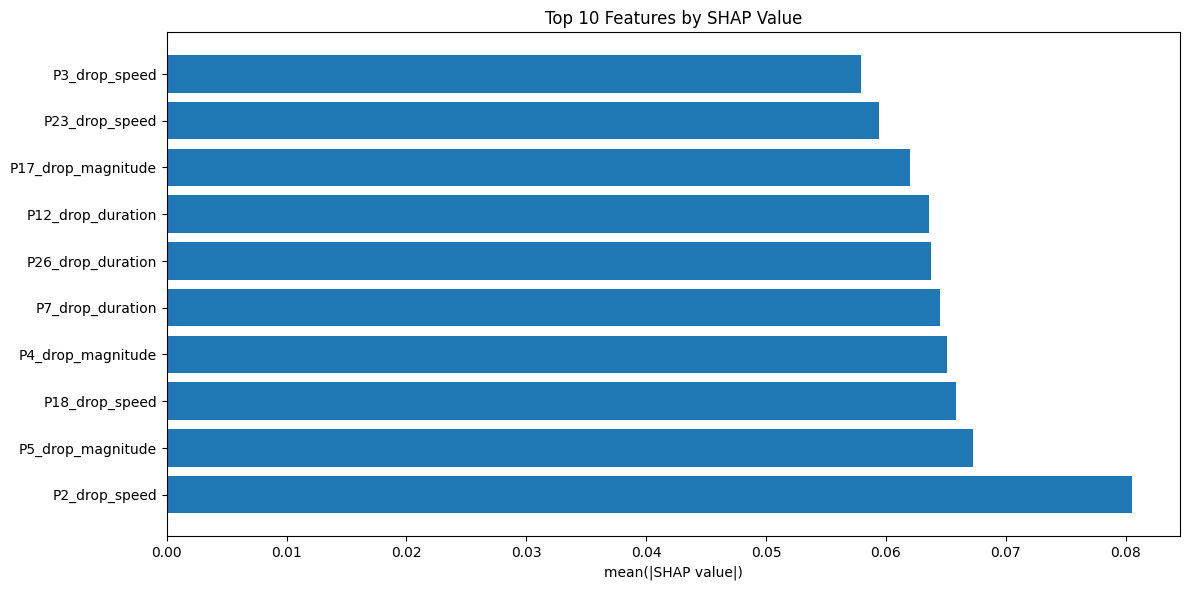


Top 10 Most Important Features:
P2_drop_speed: 0.0805
P5_drop_magnitude: 0.0673
P18_drop_speed: 0.0659
P4_drop_magnitude: 0.0651
P7_drop_duration: 0.0646
P26_drop_duration: 0.0637
P12_drop_duration: 0.0636
P17_drop_magnitude: 0.0620
P23_drop_speed: 0.0594
P3_drop_speed: 0.0580


In [32]:
# feature importance를 DataFrame으로 변환
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
})

# 중요도 기준 정렬 및 상위 10개 추출
top_10_features = importance_df.sort_values('importance', ascending=False).head(10)

# 시각화
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_10_features)), top_10_features['importance'])
plt.yticks(range(len(top_10_features)), top_10_features['feature'])
plt.title('Top 10 Features by SHAP Value')
plt.xlabel('mean(|SHAP value|)')
plt.tight_layout()
plt.show()

# 상위 10개 특성 출력
print("\nTop 10 Most Important Features:")
for idx, row in top_10_features.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")


In [72]:
def evaluate_predictions(df_A, results, leakage_cols):
    # 전체 데이터에 대한 통계
    total_metrics = {
        'true_anomaly': len(df_A[df_A['anomaly'] == 1]),
        'predicted_anomaly': len(results[results['iso_anomaly'] == 1]),
        'total_true_flags': sum(len(df_A[df_A[f'{col}_flag'] == 1]) for col in leakage_cols),
        'total_predicted_flags': sum(len(results[results[f'{col}_flag_pred'] == 1]) for col in leakage_cols)
    }
    
    # 압력계별 평가
    comparison_metrics = []
    for col in leakage_cols:
        true_flags = df_A[df_A['leakage'] == 1]
        predicted_flags = results[results[f'{col}_flag_pred'] == 1]
        matching_flags = len(set(true_flags.index) & set(predicted_flags.index))
        
        comparison_metrics.append({
            'Pressure': col,
            'True_Flags': len(true_flags),
            'Predicted_Flags': len(predicted_flags),
            'Matching_Flags': matching_flags,
            'Accuracy': matching_flags/len(true_flags)*100 if len(true_flags) > 0 else 0
        })
    
    metrics_df = pd.DataFrame(comparison_metrics)
    
    # 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 압력계별 Flag 비교
    x = np.arange(len(leakage_cols))
    width = 0.25
    
    ax1.bar(x - width, metrics_df['True_Flags'], width, label='True Flags', color='blue')
    ax1.bar(x, metrics_df['Predicted_Flags'], width, label='Predicted Flags', color='orange')
    ax1.bar(x + width, metrics_df['Matching_Flags'], width, label='Matching Flags', color='green')
    
    ax1.set_xlabel('Pressure')
    ax1.set_ylabel('Count')
    ax1.set_title('Flag Comparison by Pressure')
    ax1.set_xticks(x)
    ax1.set_xticklabels(leakage_cols)
    ax1.legend()
    
    # 전체 통계 비교
    labels = ['Total True\nFlags', 'Total Predicted\nFlags', 'True\nAnomaly', 'Predicted\nAnomaly']
    values = [total_metrics['total_true_flags'], 
              total_metrics['total_predicted_flags'],
              total_metrics['true_anomaly'],
              total_metrics['predicted_anomaly']]
    
    ax2.bar(range(len(labels)), values, color=['blue', 'orange', 'red', 'purple'])
    ax2.set_xticks(range(len(labels)))
    ax2.set_xticklabels(labels)
    ax2.set_title('Total Comparison')
    ax2.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # 상세 결과 출력
    print("\n=== 압력계별 평가 결과 ===")
    print(metrics_df)
    
    print("\n=== 전체 통계 ===")
    print(f"전체 실제 Flag 수: {total_metrics['total_true_flags']}")
    print(f"전체 예측 Flag 수: {total_metrics['total_predicted_flags']}")
    print(f"전체 실제 Anomaly 수: {total_metrics['true_anomaly']}")
    print(f"전체 예측 Anomaly 수: {total_metrics['predicted_anomaly']}")
    
    return metrics_df, total_metrics

In [73]:
# 평가 실행
metrics_df, total_metrics = evaluate_predictions(df_A, results, leakage_cols)

KeyError: 'leakage_flag'